# Fine-tuning with Keras and Deep Learning
https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
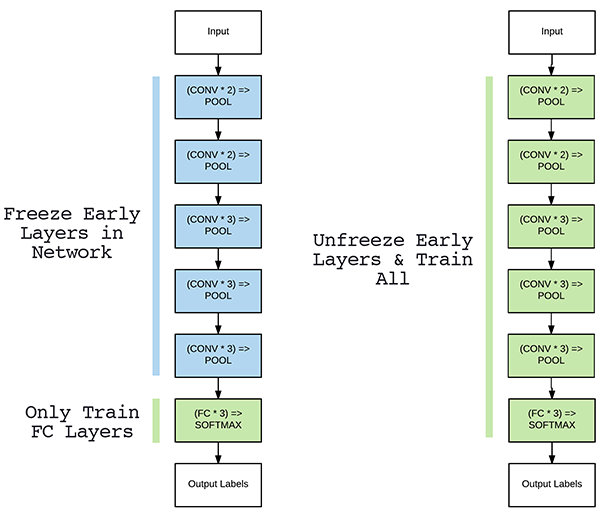

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import imutils
import pickle
import shutil
import os
import cv2

Using TensorFlow backend.


## Get dataset
`wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \ --ftp-password Cahc1moo ftp://tremplin.epfl.ch/Food-11.zip`

## Configuration

In [2]:
# Initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = "Food-11"

# Initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "dataset"

# Define the names of the training, testing, and validation directories
TRAIN = "training"
TEST = "evaluation"
VAL = "validation"

# Initialize the list of class label names
CLASSES = ["Bread", "Dairy product", "Dessert", "Egg", "Fried food", "Meat", "Noodles/Pasta",
           "Rice", "Seafood", "Soup", "Vegetable/Fruit"]

# Set the batch size when fine-tuning
BATCH_SIZE = 32

# Epochs
EPOCHS_TRAINING = 50
EPOCHS_RETRAINING = 20

# Set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["output", "food11.model"])

## Create dataset
The format will be `dataset_name/split_name/class_label/example_of_class_label.jpg` so that we can use the function `flow_from_directory` later on.

In [3]:
# Loop over the data splits
for split in (TRAIN, TEST, VAL):
    # Grab all image paths in the current split
    print("Processing '{} split'...".format(split))
    p = os.path.sep.join([ORIG_INPUT_DATASET, split])
    imagePaths = list(paths.list_images(p))

    # Loop over the image paths
    for imagePath in imagePaths:
        # Extract class label from the filename
        filename = imagePath.split(os.path.sep)[-1]
        label = CLASSES[int(filename.split("_")[0])]

        # Construct the path to the output directory
        dirPath = os.path.sep.join([BASE_PATH, split, label])
        
        # If the output directory does not exist, create it
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)

        # Construct the path to the output image file and copy it
        p = os.path.sep.join([dirPath, filename])
        shutil.copy2(imagePath, p)

Processing 'training split'...
Processing 'evaluation split'...
Processing 'validation split'...


## Fine-tuning initialization

In [4]:
def plot_training(H, N):
    # Construct a plot that plots the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

In [5]:
# Derive the paths to the training, validation, and testing directories
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
valPath = os.path.sep.join([BASE_PATH, VAL])
testPath = os.path.sep.join([BASE_PATH, TEST])

# Determine the total number of image paths in training, validation and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))

In [6]:
# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=30, zoom_range=0.15, width_shift_range=0.2, 
                              height_shift_range=0.2, shear_range=0.15, horizontal_flip=True,
                              fill_mode="nearest")

# Initialize the validation/testing data augmentation object (which we'll be adding mean subtraction to)
valAug = ImageDataGenerator()  # Only be used for mean subtraction which is why no parameters are needed

# Define the ImageNet mean subtraction (in RGB order) and set the the mean subtraction value
# for each of the data augmentation objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [7]:
# Using these generators ensures that our machine will not run out of RAM by trying to load all
# of the data at once

# Initialize the training generator
trainGen = trainAug.flow_from_directory(trainPath, class_mode="categorical", target_size=(224, 224),
                                        color_mode="rgb", shuffle=True, batch_size=BATCH_SIZE)

# Initialize the validation generator
valGen = valAug.flow_from_directory(valPath, class_mode="categorical", target_size=(224, 224),
                                    color_mode="rgb", shuffle=False, batch_size=BATCH_SIZE)

# Initialize the testing generator
testGen = valAug.flow_from_directory(testPath, class_mode="categorical", target_size=(224, 224),
                                     color_mode="rgb", shuffle=False, batch_size=BATCH_SIZE)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


## Network surgery

In [8]:
# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will *not* be updated during
# the first training process
for layer in baseModel.layers:
    layer.trainable = False

## Training

In [9]:
# Compile our model (this needs to be done after our setting our layers to being non-trainable
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("Training head...")
H = model.fit_generator(trainGen, steps_per_epoch=totalTrain // BATCH_SIZE,
                        validation_data=valGen, validation_steps=totalVal // BATCH_SIZE,
                        epochs=EPOCHS_TRAINING)

Training head...
Epoch 1/50
308/308 [==============================] - 958s 3s/step - loss: 4.5348 - accuracy: 0.2954 - val_loss: 1.5800 - val_accuracy: 0.4428
Epoch 2/50
308/308 [==============================] - 1052s 3s/step - loss: 1.9168 - accuracy: 0.3710 - val_loss: 1.6075 - val_accuracy: 0.4847
Epoch 3/50
308/308 [==============================] - 1077s 3s/step - loss: 1.7826 - accuracy: 0.3986 - val_loss: 1.8131 - val_accuracy: 0.5441
Epoch 4/50
308/308 [==============================] - 983s 3s/step - loss: 1.6513 - accuracy: 0.4408 - val_loss: 1.6950 - val_accuracy: 0.5762
Epoch 5/50
308/308 [==============================] - 949s 3s/step - loss: 1.5789 - accuracy: 0.4543 - val_loss: 1.2134 - val_accuracy: 0.5927
Epoch 6/50
308/308 [==============================] - 949s 3s/step - loss: 1.5151 - accuracy: 0.4875 - val_loss: 0.7600 - val_accuracy: 0.6233
Epoch 7/50
308/308 [==============================] - 973s 3s/step - loss: 1.4478 - accuracy: 0.5079 - val_loss: 0.7190 - v

Evaluating after fine-tuning network head...
               precision    recall  f1-score   support

        Bread       0.71      0.60      0.65       368
Dairy product       0.80      0.49      0.61       148
      Dessert       0.71      0.71      0.71       500
          Egg       0.64      0.76      0.70       335
   Fried food       0.68      0.76      0.72       287
         Meat       0.77      0.81      0.79       432
      Noodles       0.95      0.94      0.95       147
         Rice       0.90      0.90      0.90        96
      Seafood       0.78      0.80      0.79       303
         Soup       0.93      0.94      0.94       500
    Vegetable       0.91      0.88      0.90       231

     accuracy                           0.78      3347
    macro avg       0.80      0.78      0.78      3347
 weighted avg       0.78      0.78      0.78      3347



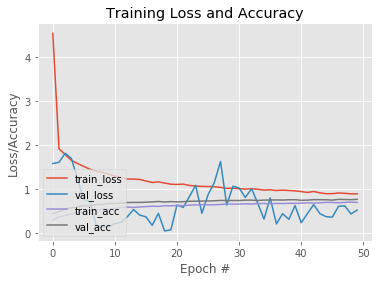

In [10]:
# Reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("Evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict_generator(testGen, steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))
plot_training(H, EPOCHS_TRAINING)

## Unfreeze the final set of conv layers

In [11]:
# Reset our data generators
trainGen.reset()
valGen.reset()

# Now that the head FC layers have been trained/initialized, let's
# unfreeze the final set of CONV layers and make them trainable
print('Total layers:', len(baseModel.layers))
for layer in baseModel.layers[15:]:
    layer.trainable = True
    
# Loop over the layers in the model and show which ones are trainable or not
for layer in baseModel.layers:
    print("{}: {}".format(layer, layer.trainable))

Total layers: 19
<keras.engine.input_layer.InputLayer object at 0x7fc0958a1f60>: False
<keras.layers.convolutional.Conv2D object at 0x7fc095891f98>: False
<keras.layers.convolutional.Conv2D object at 0x7fc0958914a8>: False
<keras.layers.pooling.MaxPooling2D object at 0x7fc095891a58>: False
<keras.layers.convolutional.Conv2D object at 0x7fc0958915c0>: False
<keras.layers.convolutional.Conv2D object at 0x7fc0955c7e48>: False
<keras.layers.pooling.MaxPooling2D object at 0x7fc095497a20>: False
<keras.layers.convolutional.Conv2D object at 0x7fc095497ba8>: False
<keras.layers.convolutional.Conv2D object at 0x7fc0951de2e8>: False
<keras.layers.convolutional.Conv2D object at 0x7fc0951dec88>: False
<keras.layers.pooling.MaxPooling2D object at 0x7fc0951e5588>: False
<keras.layers.convolutional.Conv2D object at 0x7fc0951e53c8>: False
<keras.layers.convolutional.Conv2D object at 0x7fc0951e5f28>: False
<keras.layers.convolutional.Conv2D object at 0x7fc0951eb908>: False
<keras.layers.pooling.MaxPool

## Resume training

In [12]:
# For the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit_generator(trainGen, steps_per_epoch=totalTrain // BATCH_SIZE, validation_data=valGen,
                        validation_steps=totalVal // BATCH_SIZE, epochs=EPOCHS_RETRAINING)

Epoch 1/20
308/308 [==============================] - 1069s 3s/step - loss: 0.8759 - accuracy: 0.7126 - val_loss: 1.0346 - val_accuracy: 0.7585
Epoch 2/20
308/308 [==============================] - 1067s 3s/step - loss: 0.8252 - accuracy: 0.7320 - val_loss: 0.1171 - val_accuracy: 0.7958
Epoch 3/20
308/308 [==============================] - 1067s 3s/step - loss: 0.7734 - accuracy: 0.7469 - val_loss: 0.3270 - val_accuracy: 0.7975
Epoch 4/20
308/308 [==============================] - 1067s 3s/step - loss: 0.7258 - accuracy: 0.7615 - val_loss: 0.5228 - val_accuracy: 0.7969
Epoch 5/20
308/308 [==============================] - 1066s 3s/step - loss: 0.6837 - accuracy: 0.7725 - val_loss: 0.4752 - val_accuracy: 0.8061
Epoch 6/20
308/308 [==============================] - 1065s 3s/step - loss: 0.6706 - accuracy: 0.7841 - val_loss: 0.0899 - val_accuracy: 0.8178
Epoch 7/20
308/308 [==============================] - 1066s 3s/step - loss: 0.6306 - accuracy: 0.7985 - val_loss: 0.5072 - val_accuracy:

Evaluating after fine-tuning network...
               precision    recall  f1-score   support

        Bread       0.86      0.73      0.79       368
Dairy product       0.75      0.77      0.76       148
      Dessert       0.86      0.74      0.80       500
          Egg       0.78      0.89      0.83       335
   Fried food       0.82      0.85      0.84       287
         Meat       0.83      0.93      0.88       432
      Noodles       1.00      0.94      0.97       147
         Rice       0.94      0.92      0.93        96
      Seafood       0.86      0.90      0.88       303
         Soup       0.94      0.96      0.95       500
    Vegetable       0.93      0.93      0.93       231

     accuracy                           0.86      3347
    macro avg       0.87      0.87      0.87      3347
 weighted avg       0.87      0.86      0.86      3347

Serializing network...


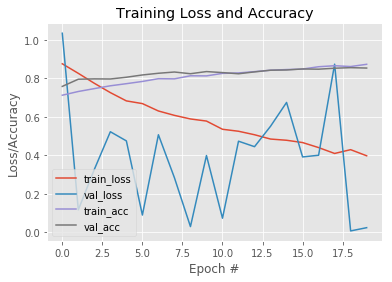

In [13]:
# Reset the testing generator and then use our trained model to
# make predictions on the data
print("Evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict_generator(testGen, steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))
plot_training(H, EPOCHS_RETRAINING)

# Serialize the model to disk
print("Serializing network...")
model.save(MODEL_PATH)

## Making predictions

In [14]:
image_path = 'dataset/evaluation/Meat/5_293.jpg'

In [15]:
# Load the input image and then clone it so we can draw on it later
image = cv2.imread(image_path)
output = image.copy()
output = imutils.resize(output, width=400)

# Our model was trained on RGB ordered images but OpenCV represents
# images in BGR order, so swap the channels, and then resize to
# 224x224 (the input dimensions for VGG16)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

# Convert the image to a floating point data type and perform mean subtraction
image = image.astype("float32")
mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
image -= mean

Loading model...


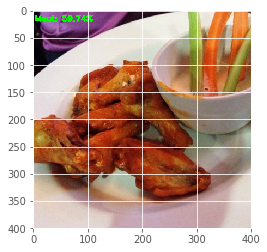

In [16]:
# Load the trained model from disk
print("Loading model...")
model = load_model(MODEL_PATH)

# Pass the image through the network to obtain our predictions
preds = model.predict(np.expand_dims(image, axis=0))[0]
i = np.argmax(preds)
label = CLASSES[i]

# Draw the prediction on the output image
text = "{}: {:.2f}%".format(label, preds[i] * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show the output image
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))